In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import seaborn as sns
from scipy.stats import norm

In [2]:
bridge2 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/Bridge 2 Depth-data-2023-03-19 22_33_44.csv')
bridge3 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/Bridge 3 Depth-data-2023-03-19 22_34_08.csv')
bridge4 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/Bridge 4 Depth-data-2023-03-19 22_34_14.csv')
bridge5 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/Bridge 5 Depth-data-2023-03-19 22_33_53.csv')

In [3]:
bridge2['Time'] = pd.to_datetime(bridge2['Time'])
bridge3['Time'] = pd.to_datetime(bridge3['Time'])
bridge4['Time'] = pd.to_datetime(bridge4['Time'])
bridge5['Time'] = pd.to_datetime(bridge5['Time'])

In [4]:
bridge2 = bridge2.set_index('Time')
bridge3 = bridge3.set_index('Time')
bridge4 = bridge4.set_index('Time')
bridge5 = bridge5.set_index('Time')

In [5]:
bridge2 = bridge2.resample('1min').mean()['depth.mean'].interpolate()
bridge3 = bridge3.resample('1min').mean()['depth.mean'].interpolate()
bridge4 = bridge4.resample('1min').mean()['depth.mean'].interpolate()
bridge5 = bridge5.resample('1min').mean()['depth.mean'].interpolate()

In [6]:
b2 = bridge2['2022-08-16':'2023-03-18']
b3 = bridge3['2022-08-16':'2023-03-18']
b4 = bridge4['2022-08-16':'2023-03-18']
b5 = bridge5['2022-08-16':'2023-03-18']

# RAW data

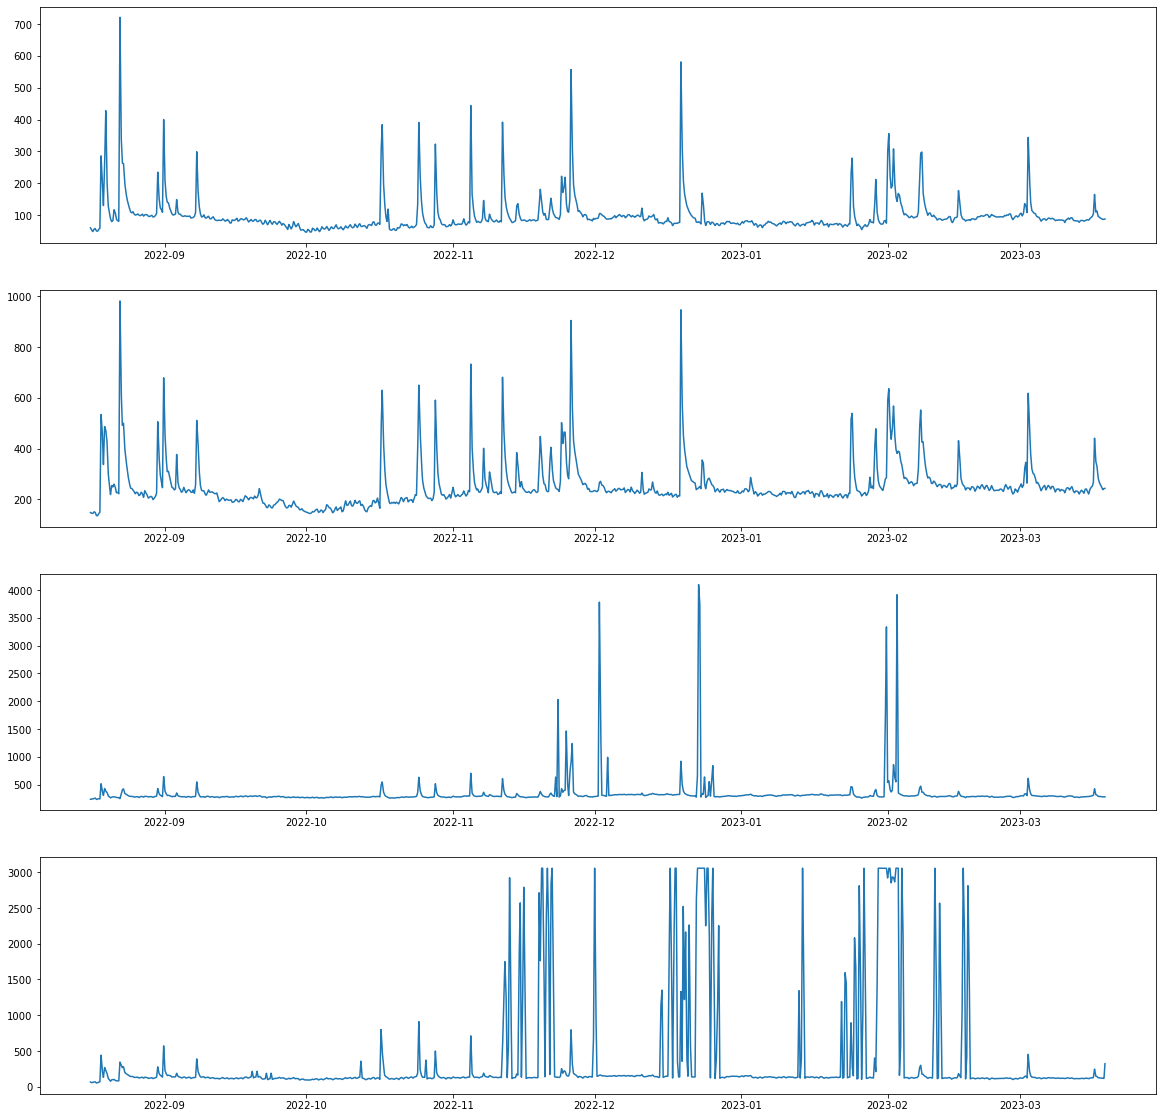

In [7]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
ax[0].plot(b2)
ax[1].plot(b3)
ax[2].plot(b4)
ax[3].plot(b5)

In [8]:
data = {'bridge2': b2, 'bridge3': b3, 'bridge4': b4, 'bridge5': b5}

# convert dictionary to DataFrame
df = pd.DataFrame(data)

print(df.head())

                       bridge2     bridge3     bridge4    bridge5
Time                                                             
2022-08-16 07:00:00  60.000000  148.000000  238.000000  66.000000
2022-08-16 07:01:00  59.982222  147.991667  238.002778  65.973056
2022-08-16 07:02:00  59.964444  147.983333  238.005556  65.946111
2022-08-16 07:03:00  59.946667  147.975000  238.008333  65.919167
2022-08-16 07:04:00  59.928889  147.966667  238.011111  65.892222


# ML regression 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import xgboost

In [10]:
features = ['bridge2','bridge3']

outputs = ['bridge4','bridge5']

X = df[features]
y = df[outputs]

In [11]:
X_train = X['2022-08-16':'2022-11-10']
y_train = y['2022-08-16':'2022-11-10']

In [12]:
X_test = X['2022-08-16':'2023-03-18']
y_test = y['2022-08-16':'2023-03-18']

# XGBOOST

In [13]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
model = xgboost.XGBRegressor()

# set up the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# define the hyperparameter grid to search over
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 500]
}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# print the best hyperparameters and corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Best mean squared error: 1519.9426870979885


In [14]:
regr = grid_search.best_estimator_
regr.fit(X_train, y_train)
y_pred_xgb = regr.predict(X_test)

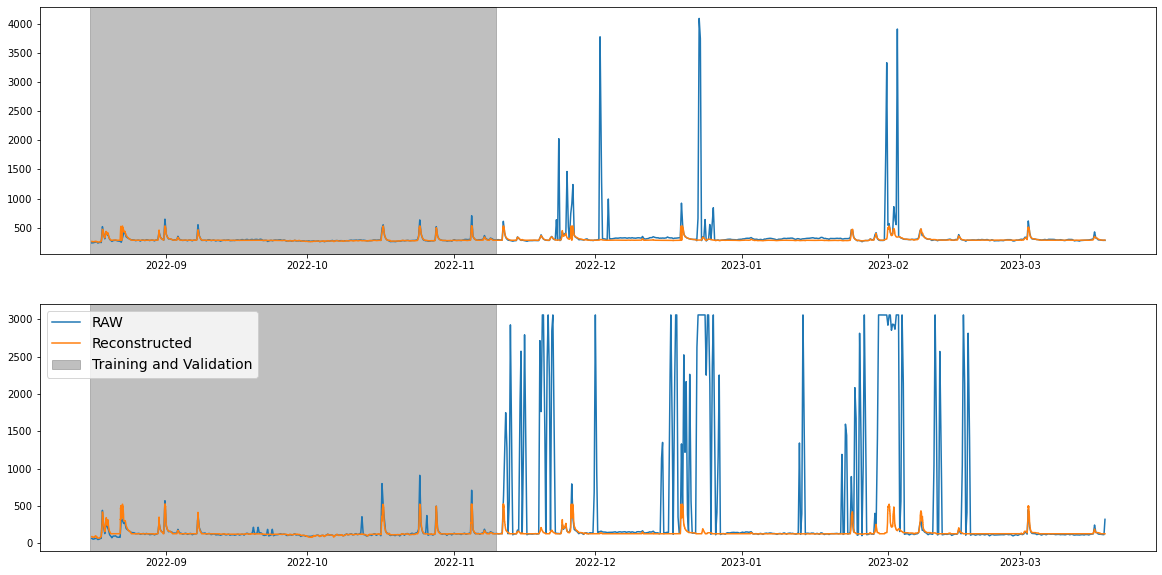

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y_test.index, y_test['bridge4'], label = 'RAW')
ax[0].plot(y_test.index, y_pred_xgb[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Training and Validation')

ax[1].plot(y_test.index, y_test['bridge5'], label = 'RAW')
ax[1].plot(y_test.index, y_pred_xgb[:,1], label = 'Reconstructed')

ax[1].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Training and Validation')
plt.legend(fontsize = 14)

# Multiple Linear Regression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# define the linear regression model
scaler = StandardScaler()
model = LinearRegression()
pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])

# set up the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# define the hyperparameter grid to search over
param_grid = {
    'model__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'model__fit_intercept': True}
Best mean squared error: 1683.4083211120214


In [17]:
scaler = StandardScaler()
model = LinearRegression(fit_intercept=True) # set best hyperparameters
pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred_lr = pipeline.predict(X_test)

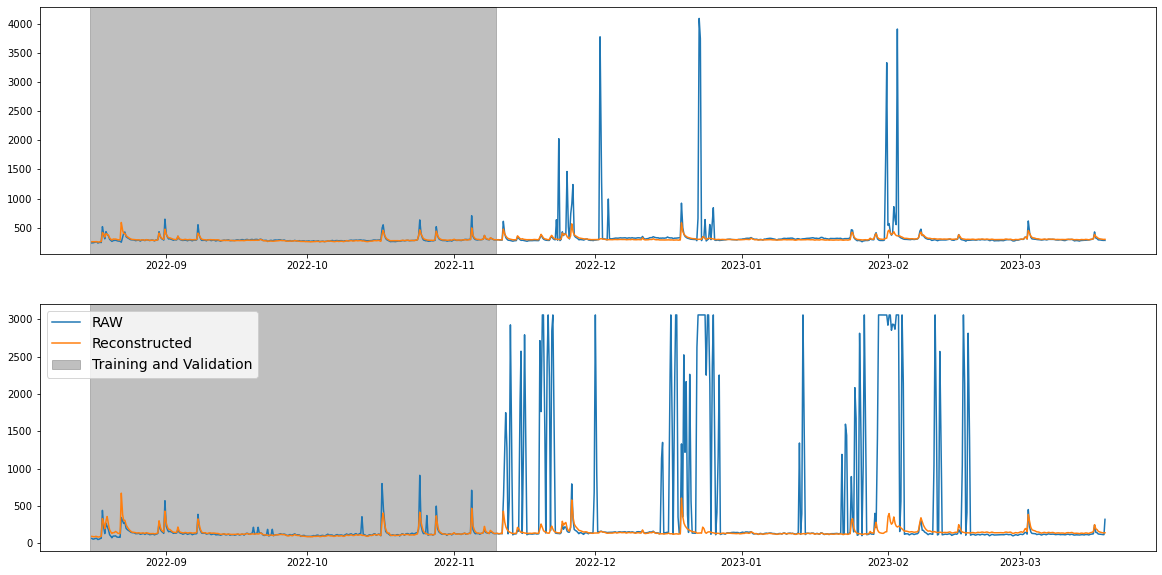

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y_test.index, y_test['bridge4'], label = 'RAW')
ax[0].plot(y_test.index, y_pred_lr[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Trainind and Validation')

ax[1].plot(y_test.index, y_test['bridge5'], label = 'RAW')
ax[1].plot(y_test.index, y_pred_lr[:,1], label = 'Reconstructed')

ax[1].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Training and Validation')
plt.legend(fontsize = 14)

# K-nearest neighbors

In [19]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

tscv = TimeSeriesSplit(n_splits=5)

# Define a range of hyperparameters to search over
param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform'}
Best mean squared error: 2408.6201917419144


In [20]:
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

y_pred_knn = best_knn.predict(X_test)

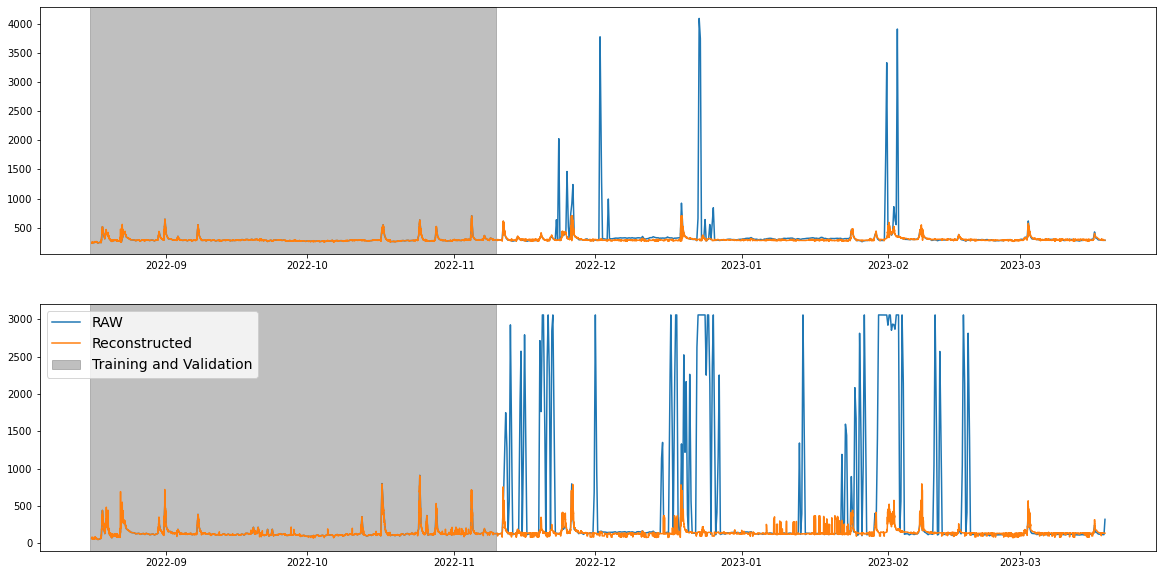

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y_test.index, y_test['bridge4'], label = 'RAW')
ax[0].plot(y_test.index, y_pred_knn[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Training and Validation')

ax[1].plot(y_test.index, y_test['bridge5'], label = 'RAW')
ax[1].plot(y_test.index, y_pred_knn[:,1], label = 'Reconstructed')

ax[1].axvspan(xmin='2022-08-16', xmax='2022-11-10', color='gray', alpha=0.5, label='Training and Validation')
plt.legend(fontsize = 14)

# Prediction

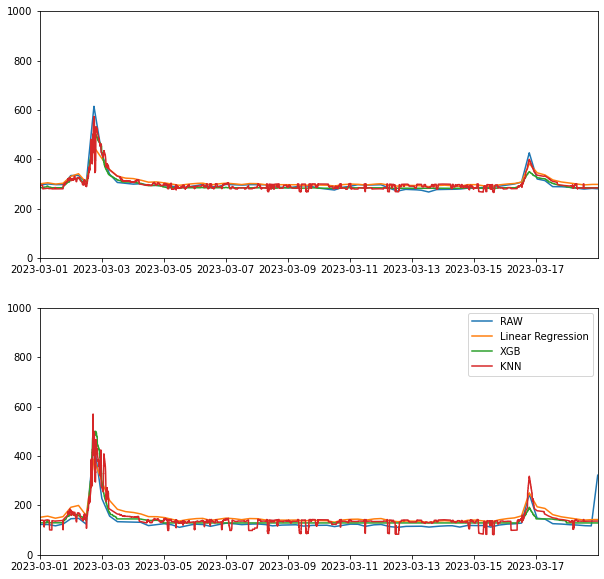

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(y_test.index, y_test['bridge4'], label = 'RAW')
ax[0].plot(y_test.index, y_pred_lr[:,0], label = 'Linear Regression')
ax[0].plot(y_test.index, y_pred_xgb[:,0], label = 'XGB')
ax[0].plot(y_test.index, y_pred_knn[:,0], label = 'KNN')
#ax[0].set_xlim('2022-09-25 00:00:00', '2023-03-10 23:59:00')
#ax[0].axvspan(xmin='2022-09-24', xmax='2022-11-10', color='gray', alpha=0.5, label='Trainind and Validation')
xmin = np.datetime64('2023-03-01 00:00:00')
xmax = np.datetime64('2023-03-18 23:59:00')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(0, 1000)

ax[1].plot(y_test.index, y_test['bridge5'], label = 'RAW')
ax[1].plot(y_test.index, y_pred_lr[:,1], label = 'Linear Regression')
ax[1].plot(y_test.index, y_pred_xgb[:,1], label = 'XGB')
ax[1].plot(y_test.index, y_pred_knn[:,1], label = 'KNN')
xmin = np.datetime64('2023-03-01 00:00:00')
xmax = np.datetime64('2023-03-18 23:59:00')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0, 1000)

#ax[1].axvspan(xmin='2022-09-24', xmax='2022-11-10', color='gray', alpha=0.5, label='Test')
plt.legend()

# Prediction score

In [23]:
a = np.where(y_test.index == '2023-03-01 00:00:00')[0]
b = np.where(y_test.index == '2023-03-18 23:59:00')[0]

In [24]:
from sklearn.metrics import r2_score
y_true = y_test[xmin:xmax]['bridge4']

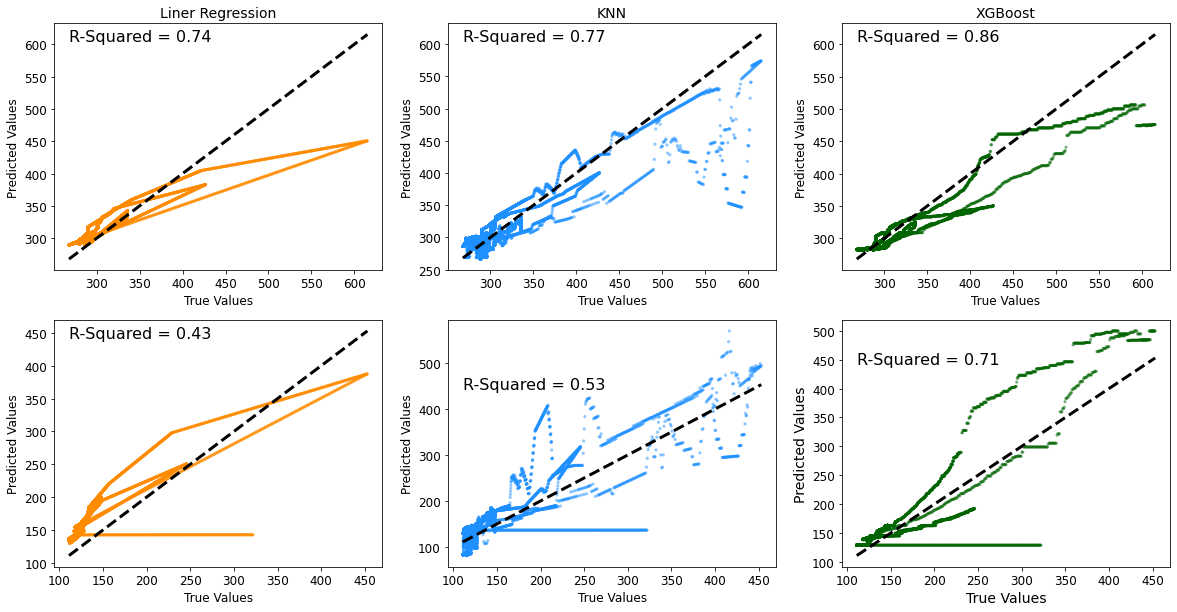

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

y_pred = y_pred_lr[a[0]:b[0]+1,0]
r2 = r2_score(y_true, y_pred)
ax[0,0].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='darkorange')
ax[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[0,0].set_xlabel('True Values', fontsize=12)
ax[0,0].set_ylabel('Predicted Values', fontsize=12)
ax[0,0].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[0,0].tick_params(axis='both', labelsize=12)
ax[0,0].set_title('Liner Regression', fontsize=14)

y_pred = y_pred_knn[a[0]:b[0]+1,0]
r2 = r2_score(y_true, y_pred)
ax[0,1].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='dodgerblue')
ax[0,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[0,1].set_xlabel('True Values', fontsize=12)
ax[0,1].set_ylabel('Predicted Values', fontsize=12)
ax[0,1].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[0,1].tick_params(axis='both', labelsize=12)
ax[0,1].set_title('KNN', fontsize=14)

y_pred = y_pred_xgb[a[0]:b[0]+1,0]
r2 = r2_score(y_true, y_pred)
ax[0,2].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='darkgreen')
ax[0,2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[0,2].set_xlabel('True Values', fontsize=12)
ax[0,2].set_ylabel('Predicted Values', fontsize=12)
ax[0,2].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[0,2].tick_params(axis='both', labelsize=12)
ax[0,2].set_title('XGBoost', fontsize=14)

y_true = y_test[xmin:xmax]['bridge5']
y_pred = y_pred_lr[a[0]:b[0]+1,1]
r2 = r2_score(y_true, y_pred)
ax[1,0].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='darkorange')
ax[1,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[1,0].set_xlabel('True Values', fontsize=12)
ax[1,0].set_ylabel('Predicted Values', fontsize=12)
ax[1,0].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[1,0].tick_params(axis='both', labelsize=12)

y_pred = y_pred_knn[a[0]:b[0]+1,1]
r2 = r2_score(y_true, y_pred)
ax[1,1].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='dodgerblue')
ax[1,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[1,1].set_xlabel('True Values', fontsize=12)
ax[1,1].set_ylabel('Predicted Values', fontsize=12)
ax[1,1].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[1,1].tick_params(axis='both', labelsize=12)

y_pred = y_pred_xgb[a[0]:b[0]+1,1]
r2 = r2_score(y_true, y_pred)
ax[1,2].scatter(y_true, y_pred, s=10, alpha=0.5, edgecolors='none', color='darkgreen')
ax[1,2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
ax[1,2].set_xlabel('True Values', fontsize=14)
ax[1,2].set_ylabel('Predicted Values', fontsize=14)
ax[1,2].text(y_true.min(), y_true.max() - 10,'\nR-Squared = {:.2f}'.format(r2), fontsize=16)
ax[1,2].tick_params(axis='both', labelsize=12)